In [1]:
import pandas as pd

import torch
from torch import nn
from transformers import LongformerForTokenClassification, LongformerTokenizer, AutoModel


from torch.utils.data import Dataset,DataLoader

from tqdm import tqdm

In [2]:
tokenized_df = pd.read_pickle('../data/preprocess_step2.pkl')

lens = [len(elem) for elem in tokenized_df['tokens']]
avg_len = sum(lens)/len(lens)

print(avg_len)

440.12517634987813


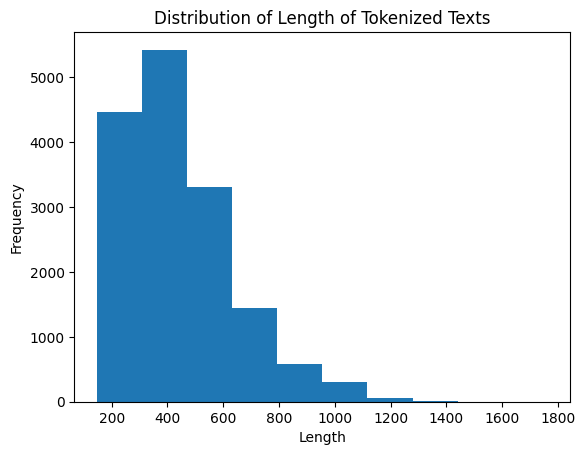

In [3]:
import matplotlib.pyplot as plt
plt.hist(lens, bins=10)  # Adjust the number of bins as needed
plt.title('Distribution of Length of Tokenized Texts')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [4]:
tokenized_df_cleaned = tokenized_df[tokenized_df["tokens"].apply(lambda x: len(x)<=200)]

longest_list = max(tokenized_df_cleaned['tokens'], key=len)
print("Number of token:", len(longest_list))


all_labels = [item for sublist in tokenized_df['aligned_tags'] for item in sublist]
unique_labels = set(all_labels)  
print(unique_labels)

Number of token: 200
{'Lead', 'Evidence', 'Counterclaim', 'Rebuttal', 'Position', 'O', 'Concluding Statement', 'Claim'}


In [5]:
# Encoding Text and Labels

tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

labels = ['O', 'Claim', 'Evidence', 'Concluding Statement', 'Rebuttal', 'Position','Counterclaim', 'Lead', 'Padding']

input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_df_cleaned['tokens']]
input_labels = [[labels.index(l) for l in tags] for tags in tokenized_df_cleaned['aligned_tags']]


In [6]:
MAX_LENGTH = len(longest_list) + 5

def pad_sequences(sequences, max_len, padding_value=0):
    return [seq + [padding_value] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences]

padded_input_ids = pad_sequences(input_ids, MAX_LENGTH, padding_value=tokenizer.pad_token_id)

padded_input_labels = pad_sequences(input_ids, MAX_LENGTH, padding_value=labels.index('Padding'))

attention_masks = [[float(token_id != tokenizer.pad_token_id) for token_id in seq] for seq in padded_input_ids]


In [7]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    device = torch.device("cpu")

else:
    device = torch.device("mps")

In [8]:
class EssayDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long).to(device),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long).to(device),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long).to(device)
        }

    def __len__(self):
        return len(self.input_ids)
    

ds = EssayDataset(padded_input_ids[:1000], attention_masks[:1000], padded_input_labels[:1000])

In [9]:
batch_size = 2

from torch.utils.data import random_split

# Define the sizes for train, validation, and test sets
total_size = len(ds)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size])

# Create data loaders for each set
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [10]:
batch_size = 2

data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [11]:
num_labels = len(unique_labels)

In [12]:
import torch
from torch import nn

class EssayDisectionModel(nn.Module):
    def __init__(self, num_labels=9, hidden_size=768):
        super(EssayDisectionModel, self).__init__()
        
        self.backbone = AutoModel.from_pretrained(
        'allenai/longformer-base-4096',
        num_labels=num_labels
        )
        
        self.dense1 = nn.Linear(hidden_size, 256)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(256, num_labels)

    def forward(self, input_ids, attention_mask):
        backbone_output = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        # x = backbone_output.logits.view(-1, self.backbone.config.hidden_size)

        print(x)
        
        x = self.dense1(backbone_output.logits)
        x = self.relu(x)
        x = self.dense2(x)
        
        return x

# model = EssayDisectionModel()

model = LongformerForTokenClassification.from_pretrained('allenai/longformer-base-4096',
        num_labels=9)

Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
torch.cuda.empty_cache()

In [14]:
import matplotlib.pyplot as plt
from transformers import AdamW

loss_fn = nn.CrossEntropyLoss()

num_epochs = 10
losses = []
val_losses = []

optimizer = AdamW(model.parameters(), lr=5e-5)

model.to(device)

model.train()
for epoch in tqdm(range(num_epochs)):
    for batch in data_loader:

        input_seq_batch = batch['input_ids']
        target_seq_batch = batch['labels']
        attention_mask = batch['attention_mask']
    
        optimizer.zero_grad()

        target_seq_hat = model(input_seq_batch, attention_mask)

        target_seq_hat = target_seq_hat.logits.view(-1, target_seq_hat.logits.shape[-1])  # [batch_size * sequence_size, num_labels]
        target_seq_batch = target_seq_batch.view(-1)

        loss = loss_fn(target_seq_hat, target_seq_batch)

        loss.backward()

        optimizer.step()
        
    losses.append(loss.item())


model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.logits.view(-1, outputs.logits.shape[-1]), targets.view(-1))
    val_losses.append(loss.item())
    

# Plotting the training losses
plt.title('Loss')
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.title('Validation Loss')
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


/Users/dhruvchandwani/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/dr/5fwr6gys3_q2mlm3nwj706880000gn/T/ipykernel_13682/1854711717.py:10: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long).to(device),
100%|██████████| 10/10 [09:56<00:00, 59.63s/it]


ValueError: too many values to unpack (expected 2)

/var/folders/dr/5fwr6gys3_q2mlm3nwj706880000gn/T/ipykernel_13682/1854711717.py:10: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long).to(device),


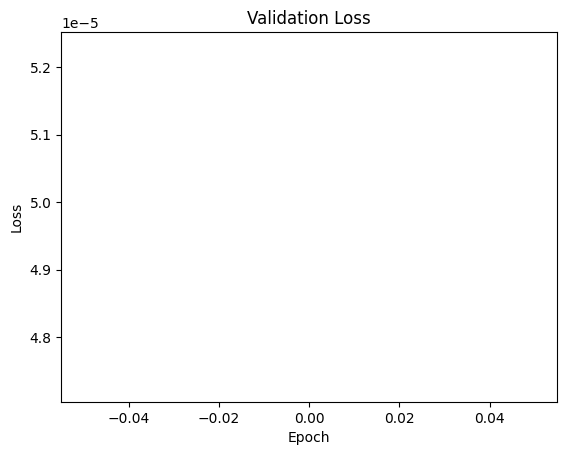

In [16]:
model.eval()
with torch.no_grad():
    for batch in val_loader:

        input_seq_batch = batch['input_ids']
        target_seq_batch = batch['labels']
        attention_mask = batch['attention_mask']

        outputs = model(input_seq_batch, attention_mask)

        loss = loss_fn(outputs.logits.view(-1, outputs.logits.shape[-1]), target_seq_batch.view(-1))
    val_losses.append(loss.item())
    
plt.title('Validation Loss')
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
total, correct, predictions = 0,0, []


model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        pred = outputs.argmax(dim=-1)
        predictions.append(pred.to("cpu").numpy())
        correct += (pred == targets).sum().item()
        total += targets.numel()

accuracy = correct/total
print(accuracy)